### Preparation - Review raw usage data

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np

import plot_helper as ph
import data_helper as dh

CSV_FILES = [
#    '../data/GlobalUsageReport 2018-05-17.csv',
    '../data/GlobalUsageReport_02-22-2018.csv',
    '../data/GlobalUsageReport_11-20-2018.csv'
]

DF = dh.load_files(CSV_FILES)

DF = DF[(DF['Product Family'] == 'Rental') &
          (DF['Collection Status'].isin(['Closed','Pending Agg','Pending Vendor']))]   

Start reading ../data/GlobalUsageReport_02-22-2018.csv... 180,857 records found
Start reading ../data/GlobalUsageReport_11-20-2018.csv... 184,814 records found


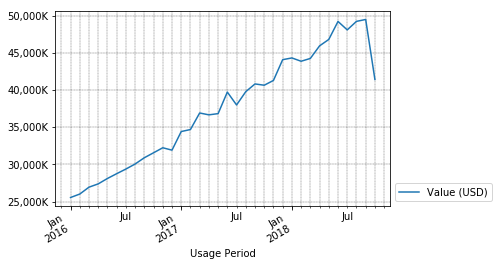

In [2]:
ph.plot_trend_chart(DF)
plt.show()

### Preparation - Configure QUARTER_RANGE in defines.py

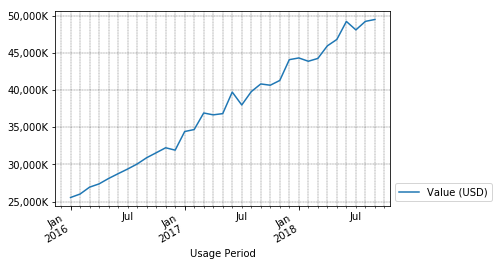

In [3]:
from defines import *

DF = DF[(DF['Usage Period']<=END_MONTH) & (DF['Usage Period']>=START_MONTH)]

ph.plot_trend_chart(DF)

### Total VCPP Revenue & Parnter Count Trend

YoY Partner Count Growth: +4%
YoY Quarterly Revenue Growth : +24%


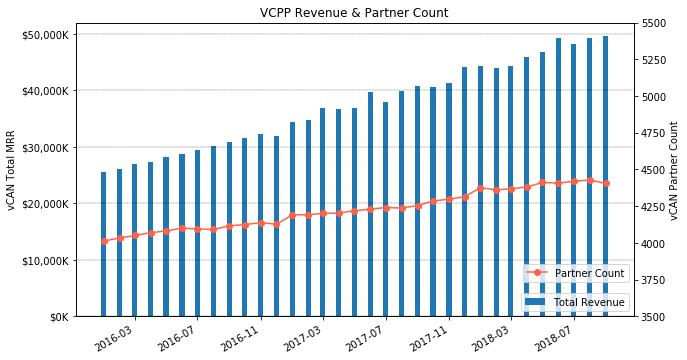

In [4]:
ph.plot_vcpp_trend(DF)

### Partner Group Name Correction

In [5]:
DF.loc[DF['Service Provider'].str.match(r'.*Softlayer*'),'Partner Group Name'] = 'IBM'
DF.loc[DF['Service Provider'].str.match(r'.*Softlayer*'),'Partner Status'] = 'Showcase'

DF.loc[DF['Service Provider'].str.match(r'OVH*'),'Partner Group Name'] = 'OVH'
DF.loc[DF['Service Provider'].str.match(r'OVH*'),'Partner Status'] = 'Showcase'

DF.loc[DF['Partner Group Name'].str.match(r'Fujitsu*'),'Partner Group Name'] = 'Fujitsu'

DF.loc[DF['Product Group'] == 'Bundle','Product Group'] = 'Bundle - SDDC'
DF.loc[DF['Product Group'] == 'Horizon','Product Group'] = 'Bundle - Horizon'


### Showcase Partner Growth Trend

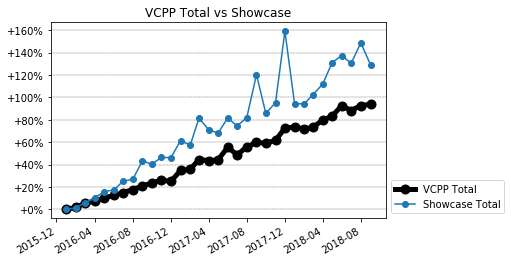

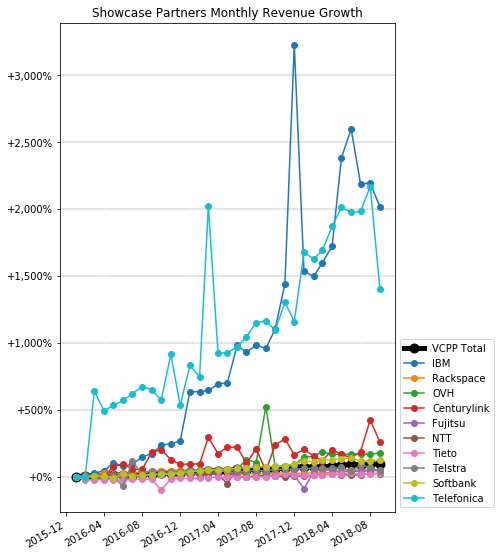

In [5]:
showcase_partners = DF[(DF['Usage Period'] == END_MONTH) &
                       (DF['Partner Status'] == 'Showcase')].groupby('Partner Group Name')['Value (USD)'].sum().sort_values(ascending=False)

def plot_rev_trend(l,data,thick=False):
    if thick:
        plt.plot(data.index,(data.values/data.values[0]-1)*100,'o-',label=l,linewidth=5.0,markersize=9.0,color='#000000')
    else:
        plt.plot(data.index,(data.values/data.values[0]-1)*100,'o-',label=l)

def plot_partner(partner):
    plot_rev_trend(partner,DF[DF['Partner Group Name']==partner].groupby('Usage Period')['Value (USD)'].sum())

def format_chart(title):
    ax = ph.format_trend_chart()
    ax.set_yticklabels(['+{:,.0f}%'.format(x) for x in ax.get_yticks()])
#    ax.legend(loc="lower right", bbox_to_anchor=(1,0))
    plt.title(title)

plot_rev_trend('VCPP Total',DF.groupby('Usage Period')['Value (USD)'].sum(),True)
plot_rev_trend('Showcase Total',DF[DF['Partner Status']=='Showcase'].groupby('Usage Period')['Value (USD)'].sum())
format_chart('VCPP Total vs Showcase')
plt.show()

plot_rev_trend('VCPP Total',DF.groupby('Usage Period')['Value (USD)'].sum(),True)
for sp in showcase_partners.index:
    plot_partner(sp) 
format_chart("Showcase Partners Monthly Revenue Growth")
plt.gcf().set_size_inches(6,10)
plt.show()


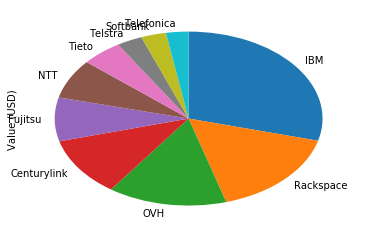

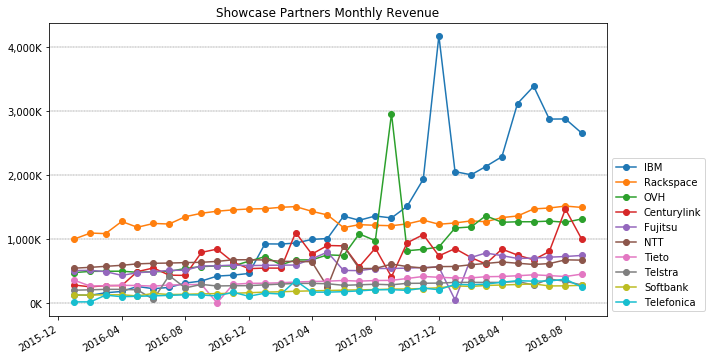

In [6]:
showcase_partners.plot.pie(startangle=90,counterclock=False)
plt.show()

for partner in showcase_partners.index:
    partner_rev = DF[DF['Partner Group Name'] == partner].groupby('Usage Period')['Value (USD)'].sum()
    plt.plot(partner_rev.index,partner_rev.values,'o-',label=partner)

ph.format_trend_chart()

plt.title("Showcase Partners Monthly Revenue")
plt.gcf().set_size_inches(10,6)
plt.show()

### Revenue Growth

In [6]:
from scipy.optimize import curve_fit

def fn_rev_growth(x,a,b):
    return b*a**x

def calc_growth_rate(df,alpha=1.0,beta=-0.5,plot=False,fit=True):
    df = df[['Usage Period','Value (USD)']].groupby(['Usage Period']).sum().reset_index()

    month_ago_rev = df['Value (USD)'].shift(1)
    mom_growth = (df['Value (USD)'] - month_ago_rev)/month_ago_rev
    mom_growth_dev = abs((mom_growth - mom_growth.mean())/mom_growth.std())

    popt = [.0,.0]
    if fit:
        popt, pcov = curve_fit(fn_rev_growth,
                               df.index[(mom_growth_dev<alpha) & (mom_growth > beta)],
                               df[(mom_growth_dev<alpha) & (mom_growth > beta)]['Value (USD)'])

    if plot:
        plt.bar(df['Usage Period'],df['Value (USD)'],15)
        if fit:
            print('growth: {}'.format(popt[0]**12))
            print('base  : {}'.format(popt[1]))
            
            plt.plot(df['Usage Period'],fn_rev_growth(df.index,popt[0],popt[1]),dashes=[6,2])
            plt.bar(df[(mom_growth_dev>=alpha) | (mom_growth <= beta)]['Usage Period'],
                    df[(mom_growth_dev>=alpha) | (mom_growth <= beta)]['Value (USD)'],15)
        fig = plt.gcf()
        fig.autofmt_xdate() 
        plt.show()   

    return popt


### Top 10 Service Providers

In [8]:
def plot_size_growth_by(df,key):
    s_top10 = df[df['Usage Period']==END_MONTH].groupby(key)['Value (USD)'].sum().sort_values(ascending=False)[:20]
    
    d = dict.fromkeys([key,'Last Month Revenue','MoM Revenue Growth','Base Revenue','Next Month Revenue Increase'])
    df_top10 = pd.DataFrame(columns=d.keys())
    for sp in s_top10.index:
        growth, base = ph.calc_growth_rate(DF[DF[key]==sp],plot=False)
        d[key] = sp
        d['Last Month Revenue'] = s_top10[sp]
        d['MoM Revenue Growth'] = growth
        d['Base Revenue'] = base
        d['Next Month Revenue Increase'] = s_top10[sp]*(growth-1)
        df_top10 = df_top10.append(d,ignore_index=True)
 
    display(df_top10)
        
    ph.plot_size_growth(df_top10[key].values,
                        df_top10['Next Month Revenue Increase'].values,
                        (df_top10['MoM Revenue Growth'].values**12-1)*100,
                        df_top10['Last Month Revenue'].values)
    
plot_size_growth_by(DF[DF['GEO']=='APAC'],'Partner Group Name')
#plot_size_growth_by('Partner Group Name')

TypeError: Improper input: N=2 must not exceed M=0

### Showcase Partner Growth Leader

Internet Initiative Japan Inc.           Japan            (APAC) $   673,240 (76%)
NTT Communications Corporation           Japan            (APAC) $   182,517 (21%)
Fujitsu Limited (Japan)                  Japan            (APAC) $   508,822 (362%)
IDC Frontier Inc.                        Japan            (APAC) $    47,207 (10%)
SoftBank Corp.                           Japan            (APAC) $   274,856 (161%)
NS Solutions Corporation                 Japan            (APAC) $   260,949 (388%)
KDDI Corporation                         Japan            (APAC) $   185,445 (157%)
CTC/ITOCHU Techno-Solutions Corp         Japan            (APAC) $   155,129 (114%)
NEC Corporation                          Japan            (APAC) $   231,437 (483%)
SCSK Corporation                         Japan            (APAC) $    57,840 (48%)
I-NET CORP.                              Japan            (APAC) $    97,358 (127%)
INTEC Inc.                               Japan            (APAC) $    82,625 (40

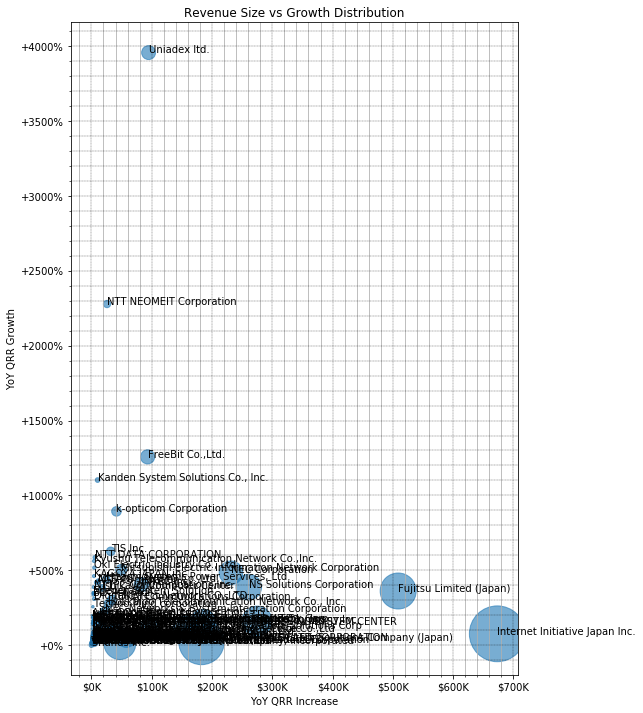

In [10]:
import size_vs_growth as sg
    
#sg.plot(DF[(DF['Partner Status']=='Showcase')],
#    {'type':['NO_SLICE'],
#     'min_rev_growth':200,
#    'show_sp_name':200},group_key='Partner Group Name')

sg.plot(DF[(DF['Country']=='Japan')],
    {'type':['NO_SLICE'],
     'min_rev_growth':100,
    'show_sp_name':100},group_key='Service Provider')

### VCPP Partners Revenue Distribution

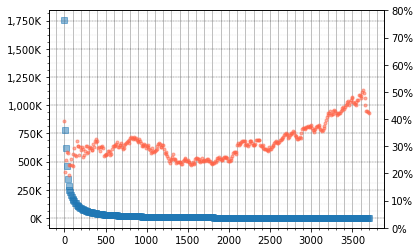

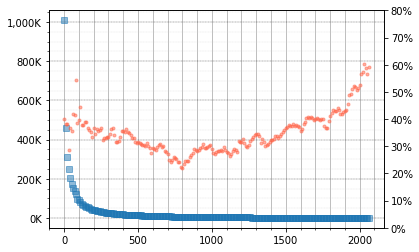

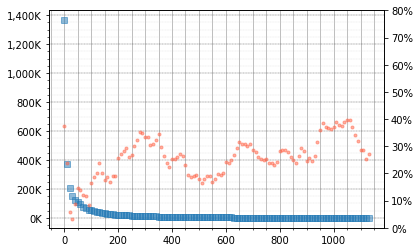

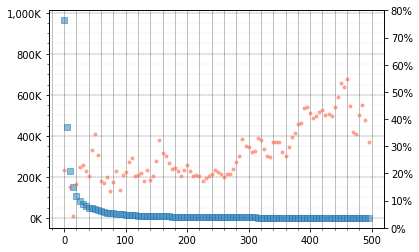

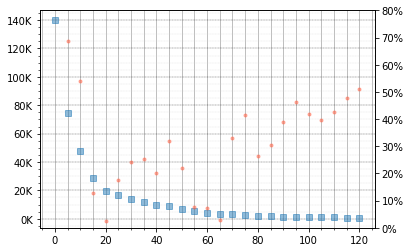

In [50]:
def df_quarter(_df,q):
    return _df[(_df['Usage Period']>=q[0])&(_df['Usage Period']<=q[2])]

def build_rank_df(df,step=100):
    s_last_sp_rev = df_quarter(df,END_QUARTER).groupby('Service Provider')['Usage Points'].sum().sort_values(ascending=False)
    s_prev_sp_rev = df_quarter(df,YEAR_AGO_QUARTER).groupby('Service Provider')['Usage Points'].sum().sort_values(ascending=False)

    df_rank = pd.DataFrame(columns=['rank_start','rank_stop','rev_prev','rev_last','increase_rate','increase_value','rev_last_month_avg'])

    for r in range(0,len(s_last_sp_rev),step):
        start, stop = r, r+step
        last = s_last_sp_rev[start:stop].sum()
        last_avg = last/(stop-start)/3 # per month per service provider
        prev = s_prev_sp_rev[start:stop].sum()
        growth_rate = (last/prev-1.0)*100
        
        if prev <= step*1000:
            break
        df_rank.loc[start] = [start,stop,prev,last,growth_rate,last-prev,last_avg]
            
    return df_rank

def plot_rank_df(df_rank):
    total_growth_rate = (df_rank.rev_last.sum()/df_rank.rev_prev.sum()-1)*100

    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
#    ax1.set_ylim(top=1200000)
    ax1.plot(df_rank.index,df_rank.rev_last_month_avg,'s',alpha=.5)
#    ax = plt.gca()
    ax1.minorticks_on()
    ax1.grid(True, which='both')
    ax1.yaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)
    ax1.yaxis.grid(which="minor", color='lightgray', linestyle='dashed', linewidth=.3)
    ax1.set_yticklabels(['{:,.0f}K'.format(y/1000) for y in ax1.get_yticks()])

    ax2.set_ylim(bottom=0,top=80)
    ax2.plot(df_rank.index,df_rank.increase_rate,'.',c='tomato',alpha=.5)
#    ax1.plot(df_rank.index,np.ones_like(df_rank.index)*total_growth_rate,'-')    
#    ax = plt.gca()
    ax2.set_yticklabels(['{:.0f}%'.format(y) for y in ax2.get_yticks()])

    plt.show()

plot_rank_df(build_rank_df(DF,step=10))
plot_rank_df(build_rank_df(DF[DF['GEO'] == 'EMEA'],step=10))
plot_rank_df(build_rank_df(DF[DF['GEO'] == 'AMER'],step=10))
plot_rank_df(build_rank_df(DF[DF['GEO'] == 'APAC'],step=5))
plot_rank_df(build_rank_df(DF[(DF['GEO'] == 'APAC') &
                              (DF['Country'] != 'Japan') &
                              (DF['Country'] != 'Australia') &
                              (DF['Country'] != 'New Zealand')
                               ],step=5))



### Showcase Partner - Group Companies Revenue Trend

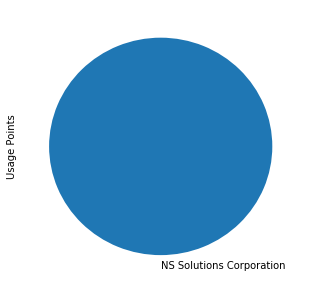

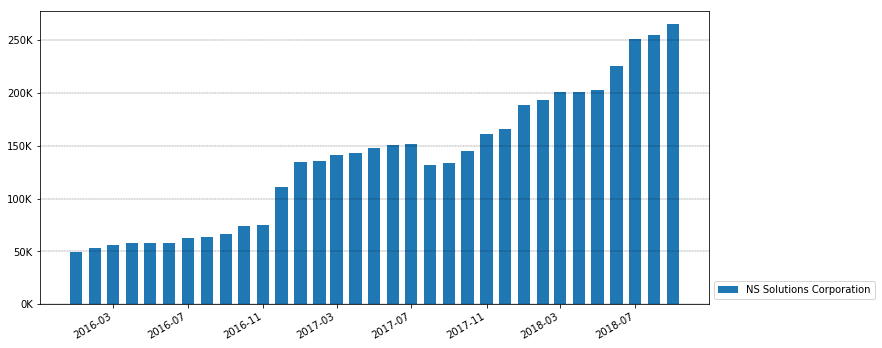

Last Month Revenue Total: 264,775


,Service Provider,Revenue Contribution,Last Month Revenue
0,NS Solutions Corporation,100.0,264775.0


growth: 1.8034479411389688
base  : 23628.850193267277


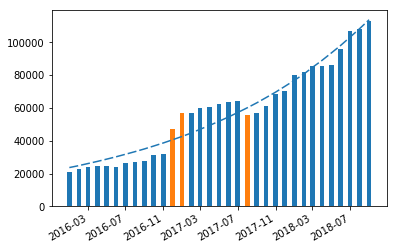

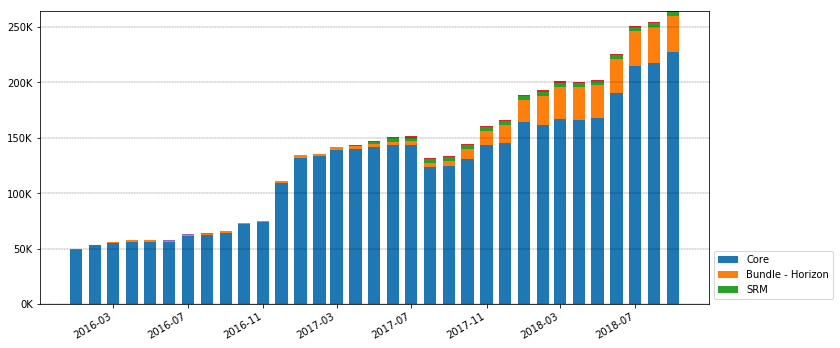

Last Month Revenue Total: 264,775


,Product Group,Revenue Contribution,Last Month Revenue
0,Core,90.650491,227390.0
1,Bundle - Horizon,7.480303,32658.0
2,SRM,1.309125,3504.0
3,vRealize Operations,0.452318,1223.0
4,Bundle - SDDC,0.107763,0.0
5,PrePay,0.000000,0.0


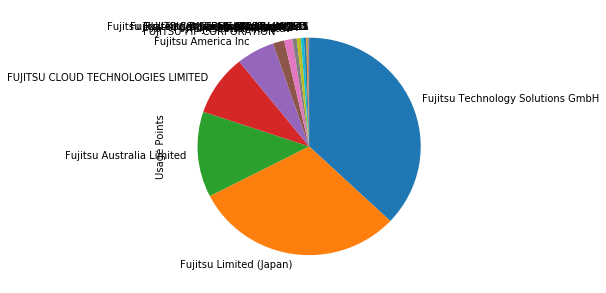

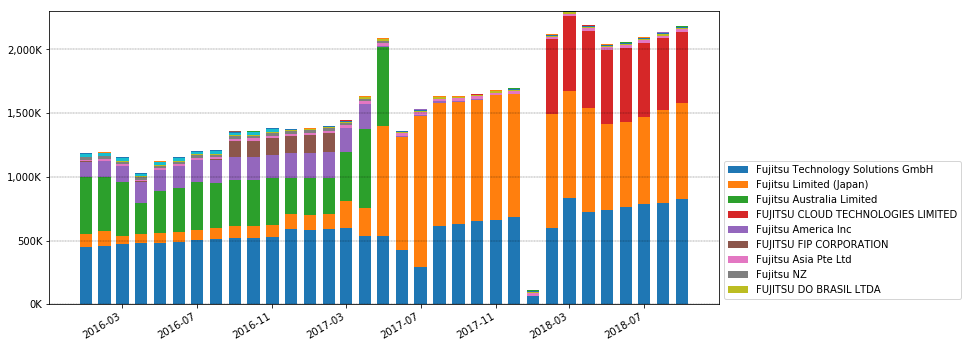

Last Month Revenue Total: 2,181,989


,Service Provider,Revenue Contribution,Last Month Revenue
0,Fujitsu Technology Solutions GmbH,37.035449,826766.0
1,Fujitsu Limited (Japan),30.411956,749763.0
2,Fujitsu Australia Limited,12.711156,0.0
3,FUJITSU CLOUD TECHNOLOGIES LIMITED,9.081221,557710.0
4,Fujitsu America Inc,5.525405,0.0
5,FUJITSU FIP CORPORATION,1.639429,0.0
6,Fujitsu Asia Pte Ltd,1.187999,22855.0
7,Fujitsu NZ,0.622956,0.0
8,FUJITSU DO BRASIL LTDA,0.594387,11263.0
9,Fujitsu Services,0.452263,0.0


growth: 1.1688656420854955
base  : 479431.1188789423


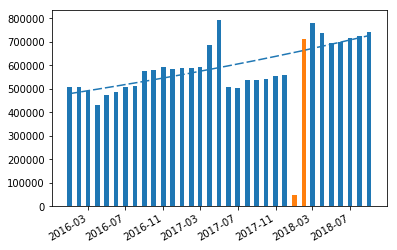

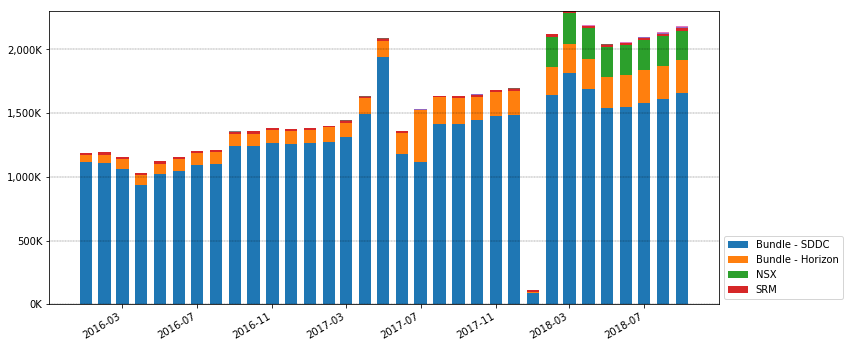

Last Month Revenue Total: 2,181,989


,Product Group,Revenue Contribution,Last Month Revenue
0,Bundle - SDDC,84.987097,1658443.0
1,Bundle - Horizon,10.010373,256131.0
2,NSX,3.701031,233200.0
3,SRM,1.058652,21360.0
4,vSAN,0.084271,7659.0
5,vRealize Automation,0.070167,10.0
6,vRealize Operations,0.050561,4676.0
7,vRealize Log Insight,0.026237,0.0
8,vCloud Availability,0.007978,510.0
9,No Group,0.003615,0.0


In [8]:
from IPython.display import HTML, Markdown, display
from plot_helper import *

def plot_pie(series):
    series.plot.pie(startangle=90,counterclock=False)
    plt.gcf().set_size_inches(5,5)
    plt.show()      

def plot_bars(series,df,value_key,series_key='Service Provider'):
    i_up = df.groupby('Usage Period')[value_key].sum().index
    total_rev = series.sum()
 
    prev_bar = 0
    d = dict.fromkeys([series_key,'Revenue Contribution','Last Month Revenue'])
    df_bars = pd.DataFrame(columns=d.keys())
    
    for sp,rev in series.items():
        df_sp = df[df[series_key] == sp]
        sp_label = sp if rev/total_rev > 0.005 else ''
 
        rev_by_period = df_sp.groupby('Usage Period')[value_key].sum() 
        for up in i_up:
            if not up in rev_by_period.keys():
                rev_by_period.at[up] = 0.0
        rev_by_period = rev_by_period.sort_index()
        d[series_key] = sp
        d['Revenue Contribution'] = rev/total_rev*100
        d['Last Month Revenue'] = rev_by_period.at[END_MONTH]
        df_bars = df_bars.append(d,ignore_index=True)
        
        plt.bar(rev_by_period.index,rev_by_period.values,width=20,label=sp_label,bottom=prev_bar)
        prev_bar += rev_by_period.values
     
    format_trend_chart()
    plt.gcf().set_size_inches(12,6)
    plt.show()  
    
    print('Last Month Revenue Total: {:,.0f}'.format(df_bars['Last Month Revenue'].sum()))
    display(df_bars)   
    
def partner_snapshot(df,
                     groupby_key='Service Provider',
                     value_key='Value (USD)',
                     product_key='Product Group'):
    # Sorted list by "value_key" size
#    s_pg_sorted = df[df['Usage Period'] == END_MONTH].groupby('Service Provider')[value_key].sum().sort_values(ascending=False)

    s_sorted = df.groupby(groupby_key)[value_key].sum().sort_values(ascending=False)

    plot_pie(s_sorted)
    plot_bars(s_sorted,df,value_key,groupby_key)
     
    calc_growth_rate(df,plot=True)

    s_prod_sorted = df.groupby(product_key)[value_key].sum().sort_values(ascending=False)
    plot_bars(s_prod_sorted,df,value_key,series_key=product_key)


#partner_snapshot(DF[DF['Product'].str.match(r'.*Horizon.*')],groupby_key='Service Provider',value_key='Usage Points')

partner_snapshot(DF[DF['Service Provider'] == 'NS Solutions Corporation'],value_key='Usage Points')

#partner_snapshot(DF[DF['Service Provider'] == 'NTT Communications Corporation'],value_key='Usage Points')
#partner_snapshot(DF[(DF['Partner Group Name'] == 'IBM')&(DF['Site Name']=='Softlayer Japan')],groupby_key='Site Name',value_key='Usage Points')
#partner_snapshot(DF[DF['Partner Group Name'] == 'IBM'],groupby_key='Site Name',value_key='Usage Points')
#partner_snapshot(DF[(DF['Partner Group Name'] == 'Fujitsu')&(DF['Site Name']=='WW_FAL')],groupby_key='Site Name',value_key='Usage Points')
partner_snapshot(DF[DF['Partner Group Name'] == 'Fujitsu'],value_key='Usage Points')
#partner_snapshot(DF[(DF['Partner Group Name'] == 'NTT') & (DF['Service Provider'] != 'NTT Communications Corporation')])

### Revenue Size vs Growth

In [ ]:
import size_vs_growth as sg

sg.plot(df[(df['Partner Group Name']=='NTT')],
    {'type':['NO_SLICE'],
     'time_frame': 'LAST_12',     
     'min_rev_growth':50,
    'show_sp_name':50})

sg.plot(DF[(DF['Country']=='Japan')],
    {'type':['NO_SLICE'],
     'time_frame': 'LAST_12',     
     'min_rev_growth':10000,
    'show_sp_name':10000})


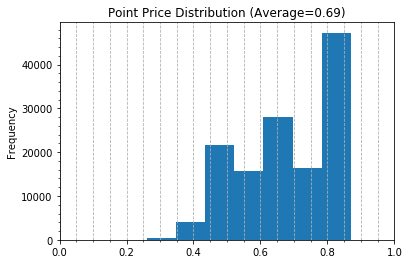

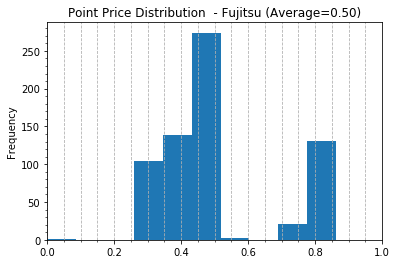

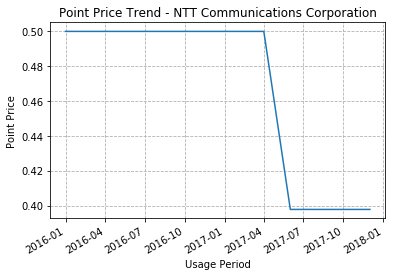

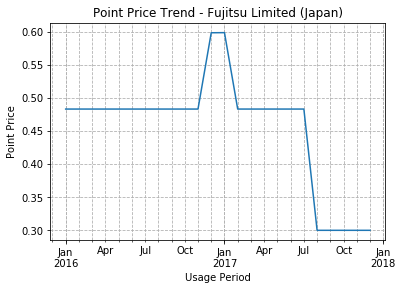

In [14]:
def plot_dist(d,caption=''):
    pp = d['Value (USD)']/d['Usage Points']

    pp.plot.hist(bins=10)
    plt.minorticks_on()
    plt.gca().xaxis.grid(True, which='both',linestyle='dashed')
    plt.xlim([0,1.0])
    plt.title("Point Price Distribution {}(Average={:.2f})".format(caption,pp.mean()))
    plt.show()

_df = df[df['Usage Points'] > 0]
_df_fujitsu = _df[_df['Partner Group Name']=='Fujitsu'].copy()

plot_dist(_df)
plot_dist(_df_fujitsu,caption=' - Fujitsu ')

def point_price_trend(sp):
    _df_sp = _df[_df['Service Provider']==sp].copy()
#    _df_sp = _df[_df['Partner Group Name']==sp].copy()
    _df_sp.loc[:,'Point Price'] = pd.Series(_df_sp['Value (USD)']/_df_sp['Usage Points'],index=_df_sp.index)

    _df_sp.groupby('Usage Period')['Point Price'].max().plot()
    plt.ylabel('Point Price')
    plt.gca().xaxis.grid(True, which='both',linestyle='dashed')
    plt.gca().yaxis.grid(True, which='both',linestyle='dashed')
    plt.title('Point Price Trend - {}'.format(sp))
    plt.show()
    

point_price_trend('NTT Communications Corporation')
point_price_trend('Fujitsu Limited (Japan)')





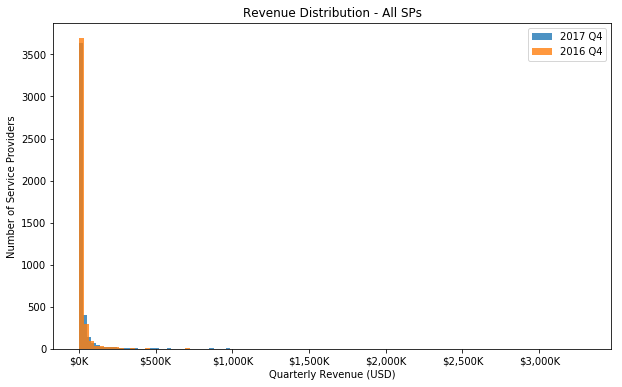

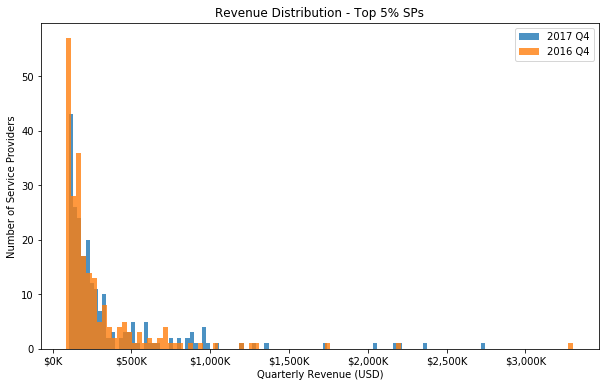

Total SP Count: 150
Top 10 SPs Contribution: 72%
Internet Initiative Japan Inc.       1,344,965
NTT Communications Corporation       953,984
Fujitsu Limited (Japan)              796,234
FUJITSU CLOUD TECHNOLOGIES LIMITED   616,294
IDC Frontier Inc.                    525,317
SoftBank Corp.                       454,667
KDDI Corporation                     285,788
NS Solutions Corporation             247,479
NEC Corporation                      245,870
CTC/ITOCHU Techno-Solutions Corp     228,791


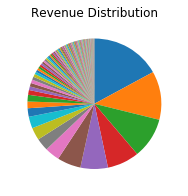

In [32]:
def df_quarter(df,Q):
    return df[(df['Usage Period'] >= Q[0]) & (df['Usage Period'] <= Q[2])]

def plot_hist(data_prev,data_last,cutoff,title):
    plt.hist(data_last[:int(len(data_last)*cutoff)],bins=100,alpha=.8,label='2017 Q4')
    plt.hist(data_prev[:int(len(data_last)*cutoff)],bins=100,alpha=.8,label='2016 Q4')

    plt.xlabel("Quarterly Revenue (USD)")
    plt.ylabel("Number of Service Providers")
    plt.title(title)
    ax = plt.gca()
    fig = plt.gcf()
    ax.set_xticklabels(['${:,.0f}K'.format(x/1000) for x in ax.get_xticks()])
    ax.legend(loc="upper right")
    fig.set_size_inches(10,6)
    plt.show()
    
df_last_q = df_quarter(DF,END_QUARTER)
df_prev_q = df_quarter(DF,YEAR_AGO_QUARTER)
data_last = df_last_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
data_prev = df_prev_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    
plot_hist(data_prev,data_last,1.0,"Revenue Distribution - All SPs")
plot_hist(data_prev,data_last,0.05,"Revenue Distribution - Top 5% SPs")
    
def print_pie(df):
    total_last = df['Value (USD)'].sum()
    s_sp_val = df.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    print("Total SP Count: {}".format(len(s_sp_val)))
    print("Top {} SPs Contribution: {:.0f}%".format(10,s_sp_val[:10].sum()/total_last*100))
    for sp,val in s_sp_val[:10].iteritems():
        print("{:36s} {:,.0f}".format(sp,val))
    
    plt.pie(s_sp_val.values,startangle=90,counterclock=False)
    plt.title('Revenue Distribution')
    plt.gcf().set_size_inches(3,3)
    plt.show()

#print_pie(df_last_q)
print_pie(df_last_q[df_last_q['Country'] == 'Japan'])



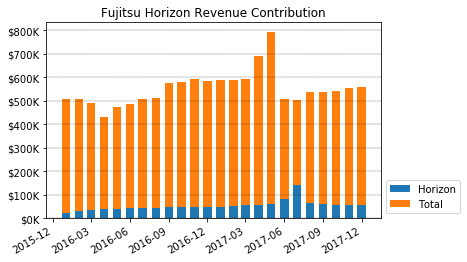

In [7]:
df_f = df[df['Partner Group Name']=='Fujitsu']
df_f_h = df_f[df_f['Product'].str.match(r'.*Horizon.*')]

total = df_f.groupby('Usage Period')['Value (USD)'].sum()
horizon = df_f_h.groupby('Usage Period')['Value (USD)'].sum()

plt.bar(total.index,horizon.values,20,label='Horizon')
plt.bar(total.index,total.values-horizon.values,20,label='Total',bottom=horizon.values)

format_trend_chart()
plt.title('Fujitsu Horizon Revenue Contribution')
plt.show()
    
#(df['Product Group']=='Horizon']


In [8]:
df_ops_map = pd.read_csv("../data/LeeMap.csv",encoding="ISO-8859-1")
df_ops_map = pd.read_csv("../data/AggregatorMap.csv",encoding="ISO-8859-1")
df_ops_map = pd.read_csv("../data/MBO_Rev_Data_Apr2018.csv")

groupnames = [
    'NTT',
    'Fujitsu',
    ['FUJITSU','Fujitsu'],
    'Rackspace',
    'Virtustream',
    'IBM',
    ['SoftLayer','IBM'],
    ['Softlayer','IBM'],    
    'Tieto',
    'OVH',
    'KPN',
    ['Kpn','KPN'],
    ['SAVVIS','CenturyLink']
]

for g in groupnames:
    pat,group = None,None
    if isinstance(g,list):
        pat,group = g
    else:
        pat,group = g,g
    df_ops_map.loc[df_ops_map['reseller'].str.match(r'.*{}.*'.format(pat)),'Partner Group Name'] = group

In [11]:


# df_group_map = pd.read_csv("../data/GroupMap.csv",encoding="ISO-8859-1")
df_last_q = df[(df['Usage Period']>=END_QUARTER[0]) & (df['Usage Period']<=END_QUARTER[2])]

ntt_groups = {
#    'ops': set(df_ops_map[df_ops_map['Global Ultimate Name match']=='NTT']['Reseller in Bookings']),
    'ops': set(df_ops_map[df_ops_map['Partner Group Name']=='NTT']['reseller']),
#    'entity_map': set(df_group_map[df_group_map['Partner Group Name']=='NTT']['Enduserorganization']),
    'usage_data': set(df_last_q[df_last_q['Partner Group Name']=='NTT']['Service Provider'])
}

fujitsu_groups = {
#    'ops': set(df_ops_map[df_ops_map['Global Ultimate Name match']=='Fujitsu']['Reseller in Bookings']),
#    'entity_map': set(df_group_map[df_group_map['Partner Group Name']=='NTT']['Enduserorganization']),
    'usage_data': set(df_last_q[df_last_q['Partner Group Name']=='Fujitsu']['Service Provider'])
}

from functools import reduce

total_rev = 0
for sp in sorted(reduce(lambda g0, g1: g0.union(g1), ntt_groups.values())):
    rev = df_last_q[df_last_q['Service Provider']==sp]['Value (USD)'].sum()
#    if rev == 0:
#        continue
    if sp in ntt_groups['usage_data'] and sp in ntt_groups['ops']:
        continue
    total_rev += rev
#    if sp in ntt_groups['ops']:
#        continue
       
    print('{:64s}: {} {} : {:10,.2f}'.format(sp,
                                        '*' if sp in ntt_groups['usage_data'] else ' ',
                                        '*' if sp in ntt_groups['ops'] else ' ',
                                         df_last_q[df_last_q['Service Provider']==sp]['Value (USD)'].sum()
                                    ))

print('{:,.2f}'.format(total_rev))
    
    

NTT Communications China Co., Ltd.                              :   * :   1,436.55
NTT DATA INC                                                    :   * :       0.00
NTT DATA ITALIA SPA	                                            :   * :       0.00
NTT DATA Inc.                                                   :   * :       0.00
NTT EUROPE ONLINE GMBH                                          :   * :       0.00
NTT Europe Online GmbH                                          : *   :  10,991.29
NTT Indonesia                                                   : *   :   1,047.60
NTT Singapore PTE Ltd                                           :   * :       0.00
NTT Singapore Pte Ltd                                           : *   :  22,657.60
PT. NTT Indonesia                                               :   * :       0.00
36,133.04


In [ ]:
# original list from Roger
ntt_groups = {
    'ops': {
        'Ingram Micro (China) Limited',
        'Insight (Software Spectrum)',
        'INSIGHT DIRECT USA, INC.',
        'Insight Techn. Solutions GmbH',
        'Networld Corp.',
        'NTT America',
        'NTT America, Inc. SME',
        'NTT Australia Pty Ltd',
        'NTT BizLink, Inc.',
        'NTT Com Asia Limited',
        'NTT Com ICT Solutions (Australia) Pty Ltd',
        'NTT Communications (Thailand) Co.,Ltd.',
        'NTT Communications China Co., Ltd.',
        'NTT Communications Corporation',
        'NTT Communications Corporation Australia Office',
        'NTT Communications Corporation Bangkok Office',
        'NTT Communications Corporation Barcelona Office',
        'NTT Communications Corporation Cyberjaya Office',
        'NTT Communications Corporation Frankfurt Office'
    },